In [1]:
# Importing the Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import sys
from scipy.stats import iqr
from scipy.stats import skew
from scipy.stats import norm, kurtosis, stats
import random
from random import sample
from sklearn.neighbors import NearestNeighbors

### Obtaining and Viewing the Data 

In [2]:
#Loading Data
#Read the .csv file into a DataFrame
raw_data = pd.read_csv('clean.csv')

print('Hotels data shape: ', raw_data.shape)

Hotels data shape:  (515212, 19)


In [3]:
raw_data.columns

Index(['additional_number_of_scoring', 'review_date', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'lat', 'lng', 'days_since_review', 'reviewer_nationality', 'hotel_name',
       'hotel_address', 'location', 'positive_review', 'negative_review',
       'tags2'],
      dtype='object')

In [4]:
#Selecting only the relevant columns
data = raw_data[['hotel_name','average_score','reviewer_score']]
data.head()

,hotel_name,average_score,reviewer_score
0,hotel arena,7.7,2.9
1,hotel arena,7.7,7.5
2,hotel arena,7.7,7.1
3,hotel arena,7.7,3.8
4,hotel arena,7.7,6.7


In [5]:
#Grouping hotels and assigning them an id
data['id_hotel'] = data.groupby(['hotel_name']).ngroup()

/Users/martavila/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
data.head()

,hotel_name,average_score,reviewer_score,id_hotel
0,hotel arena,7.7,2.9,610
1,hotel arena,7.7,7.5,610
2,hotel arena,7.7,7.1,610
3,hotel arena,7.7,3.8,610
4,hotel arena,7.7,6.7,610


In [7]:
#Double checking that it worked
data.hotel_name.value_counts()

britannia international hotel canary wharf     4789
strand palace hotel                            4256
park plaza westminster bridge london           4169
copthorne tara hotel london kensington         3577
doubletree hilton hotel london tower london    3212
                                               ... 
hotel daniel paris                               12
boundary rooms suites                            12
hotel wagner                                     10
mercure paris porte orleans                      10
hotel gallitzinberg                               8
Name: hotel_name, Length: 1492, dtype: int64

In [8]:
#Function that will limit the reviews to 600 per hotel and randomly delete the extra ones
def random_selection(data):
    if len(data['id_hotel']) > 600:
        data = data.sample(n=600, random_state = 600)
    else:
        data = data
    
    data.reset_index(drop=True, inplace=True)
    return data

In [9]:
#Applying the function to our dataset
np.random.seed(25)
df_final = data.groupby('hotel_name').apply(lambda x: random_selection(x))

In [10]:
#Double checking that it worked
df_final.hotel_name.value_counts()

thistle kensington gardens              600
radisson blu edwardian kenilworth       600
montcalm shoreditch london tech city    600
catalonia barcelona plaza               600
st george hotel wembley                 600
                                       ... 
ibis styles milano palmanova             12
le lavoisier                             12
hotel wagner                             10
mercure paris porte orleans              10
hotel gallitzinberg                       8
Name: hotel_name, Length: 1492, dtype: int64

In [11]:
#Establishing a new index
df_final.reset_index(drop=True, inplace=True)

In [12]:
#Defining a function to generate random ids to our reviewers
def gen_random_idReviewers(df_final):
    range_numbers = list(range(600))
    random_range = random.sample(range_numbers, len(range_numbers))
    random_range = random_range[0:len(df_final.hotel_name)]
    df_final['id_reviewer'] = random_range
    return df_final  

In [13]:
#Applying the function to our dataset
np.random.seed(25)
df = df_final.groupby('hotel_name').apply(lambda x: gen_random_idReviewers(x))

In [14]:
#Double checking that it worked
df.head(10)

,hotel_name,average_score,reviewer_score,id_hotel,id_reviewer
0,11 cadogan gardens,8.7,9.6,0,552
1,11 cadogan gardens,8.7,8.8,0,85
2,11 cadogan gardens,8.7,9.2,0,21
3,11 cadogan gardens,8.7,9.6,0,40
4,11 cadogan gardens,8.7,7.9,0,337
5,11 cadogan gardens,8.7,10.0,0,102
6,11 cadogan gardens,8.7,10.0,0,105
7,11 cadogan gardens,8.7,7.5,0,596
8,11 cadogan gardens,8.7,9.2,0,34
9,11 cadogan gardens,8.7,10.0,0,120


## Building a Collaborative Filtering Recommender System

- Based on the assumption that similar reviewers like similar things
- "Customers who visited this hotel also will like this one..."

### Exploratory Data Analysis

In [15]:
n_ratings = len(df)
n_hotels = df['id_hotel'].nunique() #counting how many hotels
n_reviewer = df['id_reviewer'].nunique() #counting how many reviewers

In [16]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique hotels: {n_hotels}")
print(f"Number of unique reviewers: {n_reviewer}")
print(f"Average number of ratings per reviewer: {round(n_ratings/n_reviewer, 2)}")
print(f"Average number of ratings per hotel: {round(n_ratings/n_hotels, 2)}")

Number of ratings: 389861
Number of unique hotels: 1492
Number of unique reviewers: 600
Average number of ratings per reviewer: 649.77
Average number of ratings per hotel: 261.3


In [17]:
user_freq = df[['id_reviewer', 'id_hotel']].groupby('id_reviewer').count().reset_index()
user_freq.columns = ['id_reviewer', 'n_ratings']
user_freq.head()

,id_reviewer,n_ratings
0,0,645
1,1,654
2,2,641
3,3,647
4,4,651


In [18]:
mean_n_ratings = user_freq['n_ratings'].mean()
print(f"Mean number of ratings for a given reviewer: {mean_n_ratings:.2f}.")
      

Mean number of ratings for a given reviewer: 649.77.


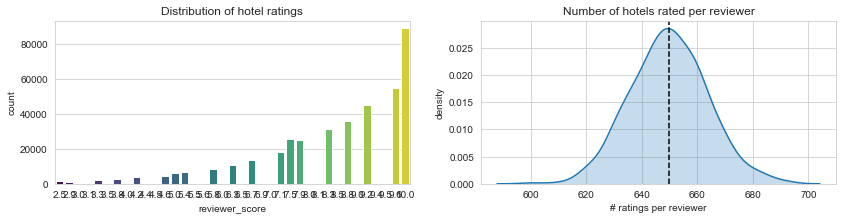

In [19]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,3))

# PLOT 1
plt.subplot(1,2,1)
ax = sns.countplot(x="reviewer_score", data=df, palette="viridis")
ax.set(title="Distribution of hotel ratings")

# PLOT 2
plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
ax.set(title="Number of hotels rated per reviewer", xlabel="# ratings per reviewer", ylabel="density")
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.show()

### Bayesian Average

- A weighted average that accounts for how many ratings there are 
- Useful when there isn't much data available
- Used extensively in baseball statistics (i.e., batting average)
- Calculate with the following equation:

$$r_{i} = \frac{C \times m + \Sigma{\text{ratings}}}{C+N} $$

<p style="margin-bottom:0;">where:</p> 

- $C$ = our confidence (average number of ratings for a given hotel)
- $m$ = our prior (global average rating)
- $N$ = total number of ratings for hotel $i$

In [20]:
df.columns

Index(['hotel_name', 'average_score', 'reviewer_score', 'id_hotel',
       'id_reviewer'],
      dtype='object')

In [21]:
hotel_stats = df.groupby('id_hotel')[['reviewer_score']].agg(['count', 'mean'])
hotel_stats.columns = hotel_stats.columns.droplevel()
hotel_stats.head()

,count,mean
id_hotel,,
0,159,8.845283
1,148,7.861486
2,600,8.974667
3,103,9.711650
4,28,9.603571


In [22]:
C = hotel_stats['count'].mean()
m = hotel_stats['mean'].mean()

def bayesian_avg(df_i):
    bayesian_avg = (C*m+df_i.sum())/(C+df_i.count())
    return bayesian_avg

In [23]:
bayesian_avg_ratings = df.groupby('id_hotel')['reviewer_score'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['id_hotel', 'bayesian_avg']
bayesian_avg_ratings.head()

,id_hotel,bayesian_avg
0,0,8.610893
1,1,8.248860
2,2,8.821036
3,3,8.819813
4,4,8.578148


### Which hotels have the highest Bayesian average rating? 

In [24]:
hotel_stats = hotel_stats.merge(bayesian_avg_ratings, on='id_hotel')
hotel_stats = hotel_stats.merge(df[['id_hotel', 'hotel_name']])

In [25]:
hotel_stats = hotel_stats.drop_duplicates()

In [26]:
hotel_stats.sort_values('bayesian_avg', ascending=False).head(10)

,id_hotel,count,mean,bayesian_avg,hotel_name
225792,883,600,9.489333,9.179563,intercontinental london o2
177357,641,301,9.718937,9.137752,hotel casa camper
8099,39,600,9.390500,9.110714,amba hotel charing cross
63219,226,437,9.476888,9.099467,catalonia square 4 sup
298731,1186,600,9.369667,9.096201,olivia plaza hotel
349449,1341,600,9.368000,9.095040,shangri la hotel shard london
298221,1185,510,9.410392,9.091220,olivia balmes hotel
335921,1302,521,9.395969,9.086102,room mate giulia
174343,628,600,9.354500,9.085635,hotel berna
9299,41,551,9.364973,9.076521,ambassade hotel


### Which hotels have the lowest Bayesian average rating?

In [27]:
hotel_stats.sort_values('bayesian_avg', ascending=True).head()

,id_hotel,count,mean,bayesian_avg,hotel_name
177883,643,600,6.446333,7.059746,hotel cavendish
76017,262,600,6.579667,7.152629,commodore hotel
111612,378,600,6.684667,7.225774,gainsborough hotel
52154,188,600,6.694167,7.232392,bloomsbury palace hotel
144613,534,463,6.566955,7.252878,hallmark hotel london chigwell prince regent


### Transforming the Data

- Need to transform data into reviewer-item matrix for collaborative filtering 
- [scipy.sparse_matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html): columns are hotels and rows are reviewers
- Each cell is populated with a reviewer's rating towards a hotel
- Empty cell = no rating available

In [28]:
df.columns

Index(['hotel_name', 'average_score', 'reviewer_score', 'id_hotel',
       'id_reviewer'],
      dtype='object')

In [29]:
from scipy.sparse import csr_matrix

def create_X(df):

    N = df['id_reviewer'].nunique()
    M = df['id_hotel'].nunique()

    reviewer_mapper = dict(zip(np.unique(df["id_reviewer"]), list(range(N))))
    hotel_mapper = dict(zip(np.unique(df["id_hotel"]), list(range(M))))
    reviewer_inv_mapper = dict(zip(list(range(N)), np.unique(df["id_reviewer"])))
    hotel_inv_mapper = dict(zip(list(range(M)), np.unique(df["id_hotel"])))
    
    reviewer_index = [reviewer_mapper[i] for i in df['id_reviewer']]
    hotel_index = [hotel_mapper[i] for i in df['id_hotel']]

    X = csr_matrix((df["reviewer_score"], (hotel_index, reviewer_index)), shape=(M, N))
    
    return X, reviewer_mapper, hotel_mapper, reviewer_inv_mapper, hotel_inv_mapper

In [30]:
X, reviewer_mapper, hotel_mapper, reviewer_inv_mapper, hotel_inv_mapper =create_X(df)

### Calculating Sparsity of the Matrix

Matrices that contain mostly zero values are called `sparse`, distinct from matrices where most of the values are non-zero, called dense.

> Large sparse matrices are common in general and especially in applied machine learning, such as in data that contains counts, data encodings that map categories to counts, and even in whole subfields of machine learning such as natural language processing.

Let's see how sparse our matrix, $X$, is. We can calculate matrix density, $d$, with the following equation:

$d=\frac{\text{# non-zero elements}}{\text{total # elements}}$

In [31]:
density = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix density: {round(density*100,2)}%")

Matrix density: 43.55%


### Finding similar hotels using k-Nearest Neighbours

k-Nearest Neighbours (kNN) is a classification algorithm that predicts the label of a given sample based on majority vote of its nearest $k$ neighbours.

Distance between two samples can be measured using `cosine similarity`, `Euclidean distance`, `Manhattan distance`, etc. 

### Cosine Similarity vs. Euclidean Distance

- **Cosine Similarity**: measures similarity of two points in orientation (i.e., the cosine angle between $A$ and $B$)
    - the closer the cosine similarity is to 1, the more similar the items are

$$\text{similairity}=\frac{A \cdot B}{\mid{A}\mid\mid{B}\mid}$$

- **Euclidean Distance**: measures distance between two items in a n-dimensional space (i.e., measures straight line from $A$ to $B$)
    - unlike cosine similarity, Euclidean distance takes magnitude into account

$$d(p,q) = \sqrt{(p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2}$$

In [32]:
# Let's create a function that finds similar hotels for a given hotel.

def find_similar_hotels(hotel_id, X, k, metric='cosine', show_distance=False):
    neighbour_ids = []
    
    hotel_ind = hotel_mapper[hotel_id]
    hotel_vec = X[hotel_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(hotel_vec, (np.ndarray)):
        hotel_vec = hotel_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(hotel_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(hotel_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

We can test out our function by passing in a `hotel_id`. We'll create a dictionary that maps `hotel_id` to hotel name so that we can better interpret our results.

In [33]:
hotel_names = dict(zip(df['id_hotel'], df['hotel_name']))

hotel_id = 1

similar_ids = find_similar_hotels(hotel_id, X, k=10)
hotel_name = hotel_names[hotel_id]

print(f"Because you stayed at {hotel_name}...")
for i in similar_ids:
    print(hotel_names[i])

Because you stayed at 1k hotel...
doubletree hilton hotel london tower london
best western premier hotel couture
park plaza county hall london
doubletree hilton london greenwich
grange st paul hotel
swiss tel amsterdam
doubletree hilton london islington
pullman paris tour eiffel
doubletree hilton london ealing
nadler victoria


**Let's repeat the process but this time using Euclidean distance**

In [34]:
hotel_names = dict(zip(df['id_hotel'], df['hotel_name']))

hotel_id = 1
similar_ids = find_similar_hotels(hotel_id, X, k=10, metric="euclidean")

hotel_name = hotel_name[hotel_id]
print(f"Because you stayed at {hotel_name}...")
for i in similar_ids:
    print(hotel_names[i])

Because you stayed at k...
ibis styles milano palmanova
ibis styles paris gare saint lazare
hotel gallitzinberg
mercure paris porte orleans
hotel silver
kube hotel ice bar
ac hotel irla marriott lifestyle hotel
hotel wagner
hilton garden inn vienna south
boundary rooms suites


## Dimensionality Reduction with Matrix Factorization

### Matrix Factorization

- A linear algebra technique that can help discover latent features between reviewers and hotels
- Latent features give a more compact representation of reviewer tastes and hotel descriptions
- Can enhance the quality of recommendations when $X$ is very sparse 
- Factorizes the reviewer-hotel matrix into two "factor matrices":
    - reviewer-factor matrix `(n_reviewers, k)`
    - hotel-factor matrix `(k, n_items)`

### Singular Value Decomposition 

- Singular Value Decomposition (SVD) is a type of matrix factorization that is used for data reduction and de-noising 
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) has a class called `TruncatedSVD` that we can use to reduce our matrix from `(n_reviewer, n_hotel)` to `(n_reviewer, n_components)` where `n_components` represents number of latent features. 

In [35]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=25, n_iter=10)
Z = svd.fit_transform(X.T)
print(f"The shape of our compressed Z matrix is: {Z.shape}.")

The shape of our compressed Z matrix is: (600, 25).


**Let's apply our `find_similar_hotels` function to our new Z matrix.**

In [36]:
hotel_id = 1
similar_hotels = find_similar_hotels(hotel_id, X=Z.T, metric='cosine', k=10)
hotel_name = hotel_names[hotel_id]

print(f"Because you stayed at {hotel_name}:")
for i in similar_hotels:
    print(hotel_names[i])

Because you stayed at 1k hotel:
25hours hotel beim museumsquartier
abbey court notting hill
acta atrium palace
ac hotel irla marriott lifestyle hotel
abba sants
academy
acca palace
ac hotel paris porte maillot marriott
ac hotel diagonal l illa marriott lifestyle hotel
ac hotel sants marriott lifestyle hotel


### Top N Recommender

- Matrix factorization allows us to predict missing ratings in our original $X$ matrix
- Reconstruct matrix by getting inner product of the reviewer-factor matrix and hotels-factor matrix

In [37]:
df.columns

Index(['hotel_name', 'average_score', 'reviewer_score', 'id_hotel',
       'id_reviewer'],
      dtype='object')

In [38]:
new_X = svd.inverse_transform(Z).T

print(f"Dimensions of original reviewer-hotel matrix: {X.shape}, {type(X)}")
print(f"Dimensions of SVD-reconstructed X matrix: {new_X.shape}, {type(new_X)}")

Dimensions of original reviewer-hotel matrix: (1492, 600), <class 'scipy.sparse.csr.csr_matrix'>
Dimensions of SVD-reconstructed X matrix: (1492, 600), <class 'numpy.ndarray'>


**Let's try generaing top N recommendations for a reviewer in our dataset. We'll look at `userId` 133. Which hotels did this reviewer rate highly?**

In [39]:
idreviewer = 133
reviewer_preferences = df[(df['id_reviewer']==idreviewer)&(df['reviewer_score']>=4)]
reviewer_preferences = reviewer_preferences.merge(df[['id_hotel', 'hotel_name']])

In [40]:
reviewer_preferences = reviewer_preferences.drop_duplicates()

In [41]:
reviewer_preferences.sort_values('reviewer_score', ascending=False).head(5)

,hotel_name,average_score,reviewer_score,id_hotel,id_reviewer
132220,hotel indigo london tower hill,9.2,10.0,700,133
227814,rembrandt,8.5,10.0,1280,133
100297,h10 urquinaona plaza,9.1,10.0,533,133
98594,h10 art gallery 4 sup,8.8,10.0,523,133
200856,olivia balmes hotel,9.3,10.0,1185,133


<p style="margin-bottom:30;">Now, let's predict which hotels userId 133 will also like based on their previous ratings. We need to do the following:</p>

- get row from $X$ which represents userId=133
- sort their predicted ratings in descending order

We can use `np.argsort()` to grab top $N$ indices for `userId=133`.

In [42]:
top_N = 10

hotel_names = dict(zip(df['id_hotel'], df['hotel_name']))

top_N_indices = new_X[reviewer_mapper[idreviewer]].argsort()[-top_N:][::-1]

print(f"Top {top_N} Recommendations for Reviewer {idreviewer}:")
for i in top_N_indices:
    hotel_id = hotel_inv_mapper[i]
    print(hotel_names[hotel_id])

Top 10 Recommendations for Reviewer 133:
home paris
h tel bourgogne montana mh
eurostars ramblas
best western boltons hotel london kensington
albus hotel amsterdam city centre
grand pigalle hotel
hotel 1898
gran hotel barcino
haymarket hotel
h tel monna lisa champs elys es
